<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/gemma_3_1b_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU

In [5]:
!nvidia-smi

Sat Aug 16 06:27:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   76C    P0             35W /   72W |    8929MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
from transformers import pipeline
from google.colab import userdata

# You must log in to the Hugging Face Hub using your access token.
# You can do this by running `huggingface-cli login` in your terminal
# or by using the `login` function in your script.
from huggingface_hub import login


token=userdata.get('HF_TOKEN')
login(token=token)

# Define the model ID.
model_id = "google/gemma-3-1b-it"

# Initialize the text-generation pipeline.
# We specify the model, device ('cuda' for GPU, 'cpu' for CPU),
# and the data type for memory efficiency.
pipe = pipeline(
    "text-generation",
    model=model_id,
    device="cuda",  # Use "cpu" if you don't have a GPU
    torch_dtype=torch.bfloat16
)

# Create a prompt using the Gemma 3 chat template.
# This template is crucial for multi-turn conversations and ensures the model
# understands the roles (user, assistant, system).
messages = [
    {"role": "user", "content": "What is the capital of France?"}
]

In [2]:
# Generate a response.
outputs = pipe(
    messages,
    max_new_tokens=256,
)

# Print the generated text from the model's response.
# The 'generated_text' will be a list of lists, so you need to
# access the content from the last message.
print(outputs[0]['generated_text'][-1]['content'])

The capital of France is **Paris**. 

It’s a common misconception that Paris is the capital of *all* of France, but it’s the political, economic, and cultural center.


In [ ]:
import torch
from transformers import AutoProcessor, pipeline
from huggingface_hub import login

from google.colab import userdata

token=userdata.get('HF_TOKEN')
login(token=token)

# Define the multimodal model ID
multimodal_model_id = "google/gemma-3-4b-it"

# Initialize the processor and pipeline
processor = AutoProcessor.from_pretrained(multimodal_model_id)
pipe = pipeline(
    "image-text-to-text",
    model=multimodal_model_id,
    device="cuda",
    torch_dtype=torch.bfloat16
)


In [ ]:
!wget https://huggingface.co/datasets/ariG23498/demo-data/resolve/main/airplane.jpg -O airplane.jpg


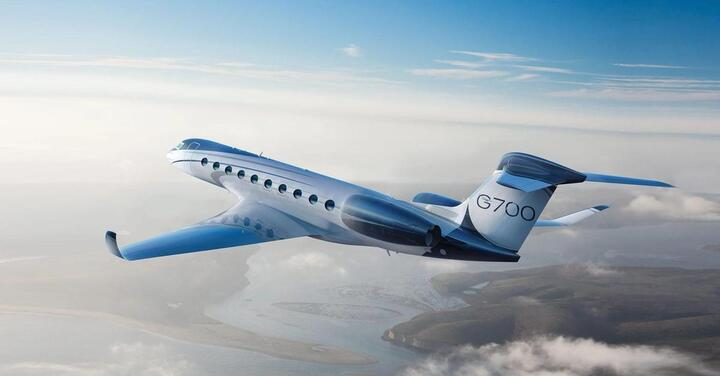

In [3]:
from IPython.display import Image
display(Image('airplane.jpg'))

In [ ]:
# Define the messages, including both image and text content
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "https://huggingface.co/datasets/ariG23498/demo-data/resolve/main/airplane.jpg"},
            {"type": "text", "text": "Describe this image."}
        ]
    }
]

# Run the pipeline with the multimodal messages
outputs = pipe(
    messages,
    max_new_tokens=32
)

# Print the model's response
print(outputs[0]["generated_text"][-1]["content"])

# TPU

## TPU PROFILE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch_xla.core.xla_model as xm

# This function will be executed on each TPU device
def _mp_fn(index, device):
    print(f"I am on device: {device}")

    # Get the number of devices available in the current distributed pod
    num_devices = xm.xla_real_devices(devkind='TPU')
    print(f"Number of TPU devices found: {len(num_devices)}")

    # Define a simple PyTorch model
    model = nn.Linear(10, 1).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Dummy data
    inputs = torch.randn(64, 10, device=device)
    labels = torch.randn(64, 1, device=device)

    for epoch in range(5):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # This synchronizes the gradients across all devices
        xm.optimizer_step(optimizer)

        # Print the loss from each device
        # xm.get_ordinal() gets the index of the current device (0, 1, 2, etc.)
        print(f"Device {xm.get_ordinal()}, Epoch {epoch+1}, Loss: {loss.item():.4f}")

if __name__ == '__main__':
    # Use torch_xla's multiprocessing to launch the _mp_fn function
    # on each available TPU device.
    import torch_xla.distributed.xla_multiprocessing as xmp

    # The 'num_cores' argument tells xmp how many devices to use.
    # Set it to None to use all available devices.
    xmp.spawn(_mp_fn, args=(), nprocs=None)

## JAX Example

In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax # for optimizers

# Define a simple neural network model
class SimpleMLP(nn.Module):
    features: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=64)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.features)(x)
        return x

# Define the loss function
@jax.jit
def apply_model(state, x, y):
    def loss_fn(params):
        y_pred = state.apply_fn({'params': params}, x)
        loss = jnp.mean((y_pred - y)**2) # Mean squared error
        return loss, y_pred

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, y_pred), grads = grad_fn(state.params)
    return grads, loss

# Define a training step
@jax.jit
def train_step(state, x, y):
    grads, loss = apply_model(state, x, y)
    state = state.apply_gradients(grads=grads)
    return state, loss

# Example usage (run on a TPU pod)
if __name__ == "__main__":
    # This code assumes a TPU backend is available.
    # Initialize the model and optimizer
    key = jax.random.PRNGKey(0)
    model = SimpleMLP(features=10)
    params = model.init(key, jnp.ones([1, 28]))['params']
    optimizer = optax.adam(learning_rate=0.001)

    state = train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=optimizer
    )

    # Generate dummy data
    dummy_x = jnp.ones([32, 28])
    dummy_y = jnp.zeros([32, 10])

    # Run a training step
    state, loss = train_step(state, dummy_x, dummy_y)
    print(f"Loss after one step: {loss}")

Loss after one step: 0.390408992767334


## PyTorch/XLA Example

In [ ]:
import torch
import torch_xla.core.xla_model as xm
import torch.nn as nn
import torch.optim as optim

# Define a simple PyTorch model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Main function to run on a TPU device
def train_model():
    # Get the TPU device
    device = xm.xla_device()

    # Create model, loss function, and optimizer
    model = SimpleModel().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Dummy data
    inputs = torch.randn(64, 10, device=device)
    labels = torch.randn(64, 1, device=device)

    # Training loop
    for epoch in range(10):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # This is the key line for PyTorch/XLA.
        # It's a barrier that waits for all devices to complete their gradient computation.
        xm.optimizer_step(optimizer)

        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Run the training loop on the TPU
if __name__ == '__main__':
    train_model()

## Fine-Tuning Code on a TPU

Fine-tuning the google/gemma-3-1b-it model on a TPU is a powerful way to adapt it to your specific use case. The most common and recommended approach is to use the PyTorch/XLA framework within a Google Cloud Vertex AI or Kaggle environment, as this provides a managed TPU runtime.

Steps for Fine-Tuning
The following code provides a comprehensive example of a fine-tuning script. The script uses the transformers library with PyTorch/XLA to enable the training on a TPU. The process involves:

1. Environment Setup: Installing the necessary libraries for PyTorch and TPU access.

2. Dataset Preparation: Loading and formatting your training data.

3. Model Loading: Loading the base Gemma-3-1b-it model and tokenizer.

4. Training Arguments: Defining the training parameters.

5. Trainer Initialization: Setting up the Trainer class from the transformers library, which handles the training loop.

6. Training Execution: Starting the fine-tuning process.

In [ ]:
!pip install datasets -q

In [5]:
from datasets import load_dataset
from IPython.display import display, Image

# Load the dataset
dataset = load_dataset("Abirate/english_quotes")

# The dataset is text-based and does not contain images.
# I'll display a sample quote instead.
print("Dataset loaded successfully. This dataset contains text quotes, not images.")
print("\nHere is a sample quote from the training split:")

# Display a sample quote
sample_quote = dataset['train'][20]['quote']
print(sample_quote)

Dataset loaded successfully. This dataset contains text quotes, not images.

Here is a sample quote from the training split:
“Without music, life would be a mistake.”


In [1]:
import torch
import os
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, BitsAndBytesConfig
from datasets import load_dataset
from huggingface_hub import login
from google.colab import userdata
import warnings
warnings.filterwarnings("ignore")

# Hugging Face Login
token = userdata.get('HF_TOKEN')
login(token=token)

# Check if PyTorch/XLA is available and on a TPU device
try:
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
    print("TPU device found. Using PyTorch/XLA for training.")
    print(f"Number of Devices: {len(xm.get_xla_supported_devices())}")
except ImportError:
    print("torch_xla not found. This script is designed for TPU environments.")
    exit()

TPU device found. Using PyTorch/XLA for training.
Number of Devices: 8


In [ ]:
# 1. Model and Tokenizer Setup
model_id = "google/gemma-3-1b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'

# 2. Load and Split Dataset
# Load the dataset and split it into a training set and an evaluation set.
# We're using a 90/10 split for training and evaluation.
# https://huggingface.co/datasets/Abirate/english_quotes

dataset = load_dataset("Abirate/english_quotes")
dataset = dataset['train'].train_test_split(test_size=0.1)

train_dataset = dataset['train']
eval_dataset = dataset['test']

# 3. Preprocess Dataset
def tokenize_function(examples):
    text = [f"### Instruction:\nFine-tune a model to generate inspirational quotes.\n### Quote:\n{q}\n" for q in examples["quote"]]
    tokenized_inputs = tokenizer(text, truncation=True, padding="max_length", max_length=128)
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy() # Add labels for causal language modeling
    return tokenized_inputs

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# 4. Load the Model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    attn_implementation='eager'
).to(device)

In [ ]:
# 5. Training Arguments
# Enable evaluation by setting `evaluation_strategy` and `load_best_model_at_end`.
training_args = TrainingArguments(
    output_dir="./gemma-3-1b-finetuned",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,  # Add batch size for evaluation
    gradient_accumulation_steps=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="epoch", # Evaluate at the end of each epoch
    load_best_model_at_end=True, # Load the model with the best evaluation loss
    metric_for_best_model="eval_loss",
    report_to="none"
)

# 6. Trainer Initialization
# Provide both the training and evaluation datasets to the Trainer.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset, # Pass the evaluation dataset
    tokenizer=tokenizer,
)

# 7. Start Training
print("Starting fine-tuning...")
trainer.train()

# 8. Save the fine-tuned model
trainer.save_model("./gemma-3-1b-finetuned")
print("Fine-tuning complete. Model saved.")

Starting fine-tuning...


Epoch,Training Loss,Validation Loss
